In [1]:
import jieba
import jieba.posseg as pseg
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# 数据预处理
- 流程
    1. 将人名列表添加`tag=jyn`，得到人名词典`name_dict.txt`，以便后续分词
    2. jieba 加载此词典
    3. 分词，得到处理后只保留人名的小说文本
- 预处理的中间结果均在`tmp`目录下


In [2]:
dataset_path = '../dataset/'
tmp_path = '../tmp/'

os.makedirs(tmp_path, exist_ok=True)
tag = 'jyn'

with open(os.path.join(dataset_path, 'name_list.txt'), 'r', encoding='utf-8') as in_file :
    with open(os.path.join(tmp_path, 'name_dict.txt'), 'w', encoding='utf-8') as out_file:
        for line in in_file:
            out_file.write(line.rstrip() + ' ' + tag + '\n')
            

jieba.load_userdict(os.path.join(tmp_path, 'name_dict.txt'))

novel_list = os.listdir(os.path.join(dataset_path, 'novels'))

os.makedirs(os.path.join(tmp_path, 'processed_novel'), exist_ok=True)

for novel in novel_list:
    with open(os.path.join(dataset_path, 'novels', novel), 'r', encoding='utf-8') as in_file:
        with open(os.path.join(tmp_path, 'processed_novel', novel), 'w', encoding='utf-8') as out_file :
            for line in in_file:
                name_list = [w.word for w in pseg.cut(line) if w.flag=='jyn']
                if name_list :
                    out_file.write(' '.join(name_list) + '\n')
                    

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\dtxlj\AppData\Local\Temp\jieba.cache
Loading model cost 1.161 seconds.
Prefix dict has been built succesfully.


# 人名同现统计
以每一段为单位，进行人名同现（cooccurring）统计

In [3]:
cooccur_matrix = {}

def cooccur_count(name_list):
#    assert len(name_list) >= 2
    n = len(name_list)
    for i in range(0,n):
        for j in range(0,n):
            if i == j :
                continue
            a, b = name_list[i], name_list[j]
            if a not in cooccur_matrix:
                cooccur_matrix[a] = {b:1}
            else :
                cooccur_matrix[a][b] = cooccur_matrix[a].get(b, 0) + 1

for novel in os.listdir(os.path.join(tmp_path, 'processed_novel')):
    with open(os.path.join(tmp_path, 'processed_novel', novel), 'r', encoding='utf-8') as f:
        for line in f :
            name_list = list(set(line.split()))
            if len(name_list) >=2 :
#                cooccur_count(sorted(name_list))
                cooccur_count(name_list)

# 绘制人物关系热力图

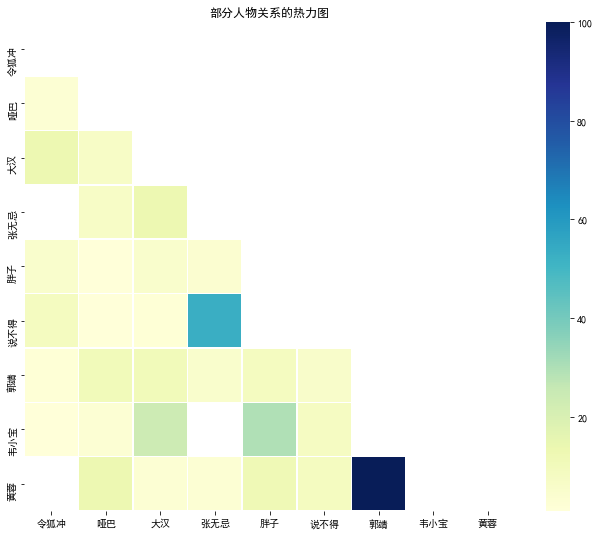

In [4]:
df = pd.DataFrame(cooccur_matrix)
dropped_df = df.dropna(axis=0, thresh=150)
symmetric_dropped_df = dropped_df.loc[:,dropped_df.index]

# Generate a mask for the upper triangle
mask = np.zeros_like(symmetric_dropped_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(11, 9))
plt.rc('font', family='SimHei')
sns.heatmap(symmetric_dropped_df, mask=mask, cmap='YlGnBu', vmax=100, linewidths=.5)
plt.title('部分人物关系的热力图')
plt.show()

# 人物重要性量化（PageRank）
对共现次数进行归一化，进行PageRank值计算

In [5]:
normalized_sorted_cooccur_matrix = {}

for name,dct in cooccur_matrix.items():
    normalized_value = [ value / sum(dct.values()) for value in dct.values() ]
    normalized_sorted_cooccur_matrix[name] = \
        dict(sorted(zip(dct.keys(),normalized_value), key=lambda d:d[1], reverse=True))


pg_values = dict.fromkeys(normalized_sorted_cooccur_matrix.keys(), 1)


d = 0.85
pagerank_T = 10

for i in range(pagerank_T):
    pg_rec_total_values = dict.fromkeys(normalized_sorted_cooccur_matrix.keys(), 0)
    for name1, link in normalized_sorted_cooccur_matrix.items():
        for name2, weight in link.items():
            pg_rec_total_values[name2] += pg_values[name1] * weight
            
    for name in pg_values:
        pg_values[name] = pg_rec_total_values[name] * d + pg_values[name] * (1 - d)
        
sorted_pg_values = sorted(pg_values.items(), key=lambda d:d[1], reverse=True)

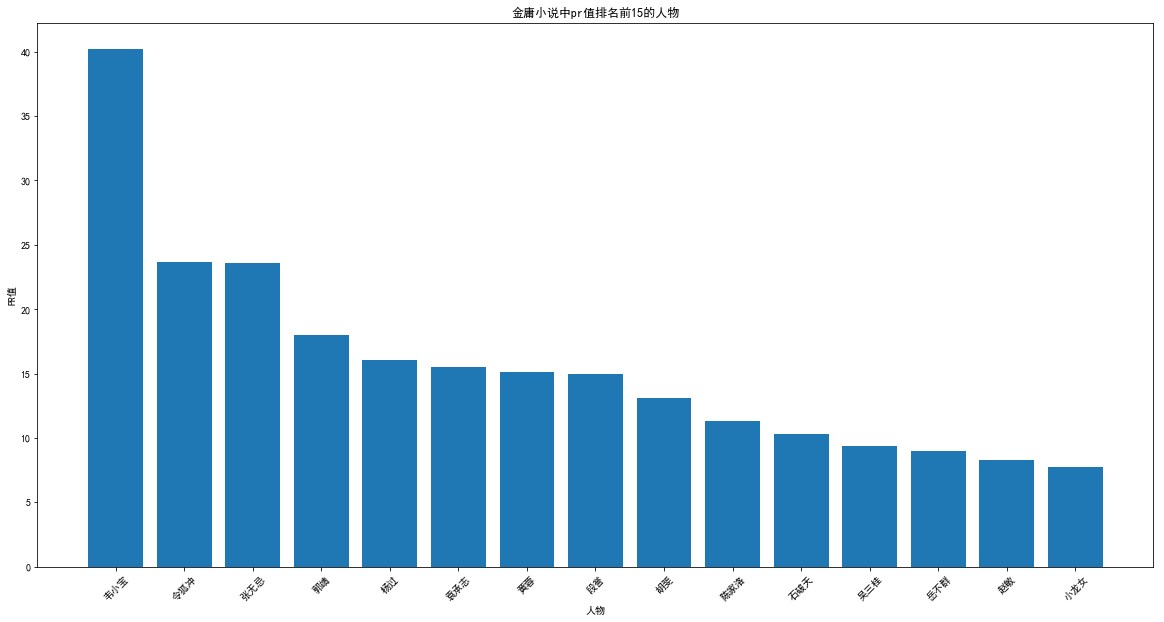

In [6]:
plt.rc('font', family='SimHei')
plt.figure(figsize=(20,10))
plt.bar(dict(sorted_pg_values[:15]).keys(),dict(sorted_pg_values[:15]).values())
plt.xticks(rotation=45)
plt.xlabel('人物')
plt.ylabel('PR值')
plt.title('金庸小说中pr值排名前15的人物')
plt.show()

# 绘制词云图

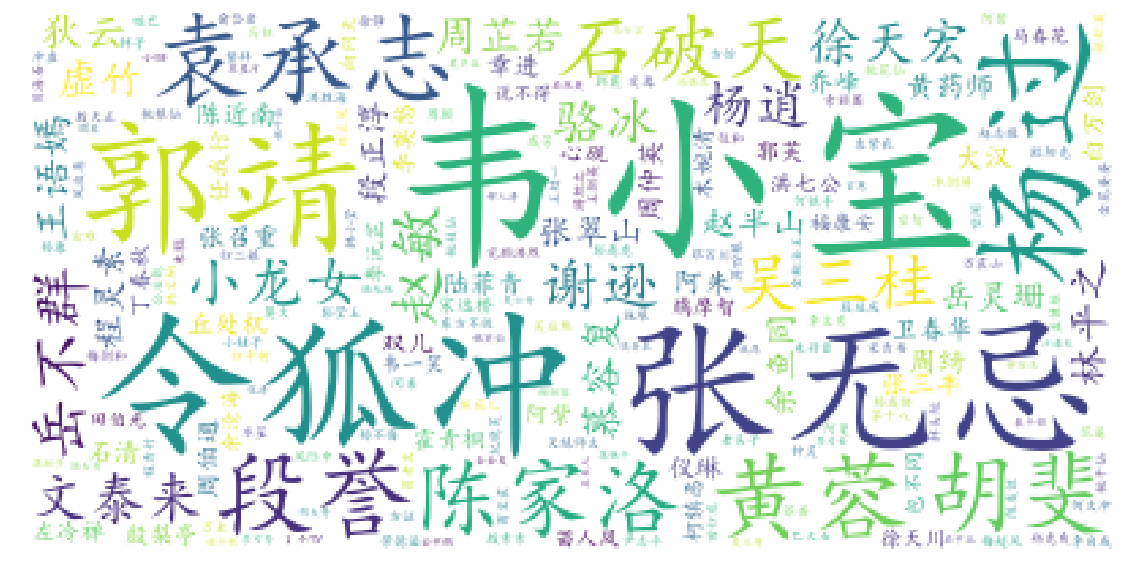

In [7]:
wc = WordCloud(background_color='white',font_path=r'C:\Windows\Fonts\simkai.ttf')
wc.generate_from_frequencies(dict(sorted_pg_values))
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

# 人物关系分析（Label Propagation）
初始化各人物互不相同的标签，基于同现次数，进行标签传播

In [8]:
name_label = dict(zip(cooccur_matrix.keys(), cooccur_matrix.keys()))

labelprop_T = 10

for i in range(labelprop_T):
    new_name_label = dict.fromkeys(cooccur_matrix.keys(), None)
    
    for name1, link in cooccur_matrix.items():
        lp_rec_total_times = dict.fromkeys(name_label.values(), 0)
        
        for name2, time in link.items():
            lp_rec_total_times[name_label[name2]] += time

        new_name_label[name1] = max(lp_rec_total_times.items(), key = lambda d:d[1])[0]
        
    name_label = new_name_label
    
labels = list(set(name_label.values()))
label_name = dict.fromkeys(labels, [])
for name, label in name_label.items():
    label_name[label].append(name)

# 人物关系图展示（由gephi生成）
- 全局展示
    ![全局](../pic/result1.jpg)
    
- 局部1
    ![局部1](../pic/result2.jpg)
    
- 局部2
    ![局部2](../pic/result3.jpg)